# Automatic Manga Creator

In [ ]:
!pip install diffusers transformers accelerate

In [7]:
import torch
import json
import openai
import os
import textwrap
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image, ImageDraw, ImageFont

pipeline = StableDiffusionPipeline.from_pretrained(
    "stablediffusionapi/anything-v5",
    torch_dtype=torch.float16, safety_checker=None,
    custom_pipeline="lpw_stable_diffusion"
).to("cuda")

pipeline.load_textual_inversion(
    "sayakpaul/EasyNegative-test",
    weight_name="EasyNegative.safetensors",
    token="EasyNegative"
)
pipeline.load_textual_inversion(
    "mlhub/embeddings",
    weight_name="./veryBadImageNegative/verybadimagenegative_v1.3.pt",
    token="verybadimagenegative"
)

pipeline.load_textual_inversion(
    "mlhub/embeddings",
    weight_name="./badhand/badhandv4.pt",
    token="badhandv4"
)
pipeline.load_lora_weights("xiaozaa/animaTest", weight_name="animeoutlineV4_16.safetensors")

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    pipeline.scheduler.config, use_karras_sigmas=True
)

class ChatApp:
    def __init__(self):
        # Setting the API key to use the OpenAI API
        openai.api_key = os.getenv("OPENAI_API_KEY")
        self.messages = [
            {"role": "system", "content": """You are a manga artist who create 4 panel manga. You have to understand the scene of each panels and the dialogues in each one. Please describe using strictly adjectives. 5 adjectives for the background, 10 adjectives for each character's looks and 10 adjectives their action,expression, and position. Adjectives should be delimited by comma. Add dialogue separate from the description.
                Format your response as string with the following structure:
                {
                  "panel{number}": {
                    "background": {
                      "description": []
                    },
                    "characters": {
                      "character1_name": {
                        "looks": [],
                        "action": [],
                        "expression":[],
                        "position"[]
                      },
                      "character2_name": {
                        "looks": [],
                        "action": [],
                        "expression":[],
                        "position"[]
                      }
                    },
                    "dialogues": {
                      "character1_name": "",
                      "character2_name": ""
                    }
                  }
                }"""},
        ]

    def chat(self, message):
        self.messages.append({"role": "user", "content": message})
        response = openai.ChatCompletion.create(
          model="gpt-3.5-turbo",
          messages=self.messages,
          temperature=0.4,
          max_tokens=2000
        )
        self.messages.append({"role": "assistant", "content": response["choices"][0]["message"].content})
        return response["choices"][0]["message"]

    def get_input(self):
        plotline = input("Enter the basic plotline: ")

        characters = {}
        print("Please enter 2 characters")
        for i in range(2):
            character_name = input(f"Enter name of character {i+1}: ")
            character_gender = input(f"Enter gender of character (boy/girl) {i+1}: ")
            character_looks = input(f"Describe the looks and character of character {i+1} (10 words or less, separated by comma): ").split(',')

            characters[character_name] = [character_gender] + character_looks

        # prepare the input message
        message = {
            "plotline": plotline,
            "character": characters,
        }

        return json.dumps(message)

def combine_descriptions(panel):
    background_description = ','.join(panel["background"]["description"])

    character_and_actions = []

    for character in panel["characters"]:
        character_looks = ','.join(panel["characters"][character]["looks"])
        character_action = ','.join(panel["characters"][character]["action"])
        character_expression = ','.join(panel["characters"][character]["expression"])
        character_position = ','.join(panel["characters"][character]["position"])
        character_and_actions.append(f'{character_looks},{character_action},{character_expression},{character_position}')

    combined = background_description + '.' + '.'.join(character_and_actions)

    return combined

def image_creator(prompt):

    # Create the prompt for Stable Diffusion based on the keywords.
    prompt = "((masterpiece, best quality)),2d, masterpiece, best quality, anime, highly detailed face, highly detailed background, perfect lighting," + prompt + ",lineart, monochrome, <animeoutlineV4_16:1>"

    negative_prompt = "EasyNegative, verybadimagenegative, badhandv4,"

    images = pipeline(prompt=prompt,
        negative_prompt=negative_prompt,
        width=768,
        height=512,
        num_inference_steps=30,
        num_images_per_prompt=1,
        generator=torch.manual_seed(0)
    ).images

    return images[0]

def create_speech_bubbles(img, dialogues, panel_number):
    # Load the image
    draw = ImageDraw.Draw(img)

    # Define the font and size
    # fnt = ImageFont.truetype('/content/drive/MyDrive/Assignment_2_Neural_Computing/animeace2bb_tt/animeace2_reg.ttf', 10)
    fnt = ImageFont.truetype('./animeace2bb_tt/animeace2_reg.ttf', 10)

    # Define the dialogue position
    width, height = img.size
    dialogue_positions = [(50, height/2), (width/2, height/2)]

    bubble_width = width // 4  # Reduced width for more upright ellipse

    # Draw speech bubbles and text for dialogues
    for i, (character, dialogue) in enumerate(dialogues.items()):
        # Check if dialogue is available for the character
        if dialogue:
            # Wrap the text to approximately 15 characters per line
            lines = textwrap.wrap(dialogue, width=15)

            # Dynamically adjust the height of the bubble based on the number of lines
            bubble_height = fnt.getsize(lines[0])[1] * (len(lines) + 1)

            # Select dialogue position
            x, y = dialogue_positions[i]

            # Draw the speech bubble with the dynamically adjusted height
            draw.ellipse([(x, y), (x+bubble_width, y+bubble_height)], outline ='black', fill ='white')

            y_text = y + bubble_height / 2 - len(lines) * fnt.getsize(lines[0])[1] / 2  # Center the text vertically
            for line in lines:
                line_width, line_height = fnt.getsize(line)
                # Draw the text in the middle of the bubble
                draw.text((x + (bubble_width - line_width) / 2, y_text), line, font=fnt, fill=(0, 0, 0))
                y_text += line_height

    # Save the image
    img.save(f'image_with_bubbles_{panel_number}.png')

    return img

text_encoder\model.safetensors not found
You have disabled the safety checker for <class 'diffusers_modules.git.lpw_stable_diffusion.StableDiffusionLongPromptWeightingPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [2]:
chat_app = ChatApp()
plot_line_and_characters = chat_app.get_input()
# plot_line_and_characters = """{"plotline":"A romantic comedy about a boy and a girl teasing each other","character":{"Aqua":["boy","tall","handsome","short hair","shy"],"Yui":["girl","short","petite","long hair","extrovert"]}}"""

response = chat_app.chat(plot_line_and_characters)

# Example
# Enter the basic plotline: A romantic comedy about a boy and a girl teasing each other.
# Please enter 2 characters
# Enter name of character 1: Aqua
# Enter gender of character (boy/girl) 1: boy
# Describe the looks of character 1 (10 words or less, separated by comma): tall,handsome,short hair,shy
# Enter name of character 2: Yui
# Enter gender of character (boy/girl) 2: girl
# Describe the looks of character 2 (10 words or less, separated by comma): short,petite,long hair,extrovert

In [8]:
response_json = json.loads(response["content"])

def process_panel(panel_data, panel_number):
    if panel_data == None:
        return
    panel_prompt = combine_descriptions(panel_data)
    print(panel_prompt)
    panel_image = image_creator(panel_prompt)
    dialogues = response_json[f"panel{panel_number}"]["dialogues"]
    panel_image_with_bubble = create_speech_bubbles(panel_image, dialogues, panel_number)
    return panel_image_with_bubble

panel1_image = process_panel(response_json.get("panel1",None), 1)
panel2_image = process_panel(response_json.get("panel2",None), 2)
panel3_image = process_panel(response_json.get("panel3",None), 3)
panel4_image = process_panel(response_json.get("panel4",None), 4)


Token indices sequence length is longer than the specified maximum sequence length for this model (100 > 77). Running this sequence through the model will result in indexing errors


sunny,park,green grass,trees,flowers.boy,tall,handsome,short hair,shy,standing,hands in pockets,blushing,center.girl,short,petite,long hair,extrovert,sitting on a bench,leaning towards Aqua,smiling,right


  0%|          | 0/30 [00:00<?, ?it/s]

sunset,beach,waves,seagulls,palm trees.boy,tall,handsome,short hair,shy,building a sandcastle,concentrating,left.girl,short,petite,long hair,extrovert,splashing water on Aqua's sandcastle,laughing,center


  0%|          | 0/30 [00:00<?, ?it/s]

rainy,classroom,chalkboard,desks,books.boy,tall,handsome,short hair,shy,writing on the chalkboard,frustrated,right.girl,short,petite,long hair,extrovert,sitting at her desk,throwing paper balls at Aqua,mischievous,left


  0%|          | 0/30 [00:00<?, ?it/s]

starlit,rooftop,city skyline,moon,twinkling lights.boy,tall,handsome,short hair,shy,holding a bouquet of flowers,nervous,center.girl,short,petite,long hair,extrovert,standing in front of Aqua,smiling,happy,center


  0%|          | 0/30 [00:00<?, ?it/s]

In [10]:
print(response_json)

{'panel1': {'background': {'description': ['sunny', 'park', 'green grass', 'trees', 'flowers']}, 'characters': {'Aqua': {'looks': ['boy', 'tall', 'handsome', 'short hair', 'shy'], 'action': ['standing', 'hands in pockets'], 'expression': ['blushing'], 'position': ['center']}, 'Yui': {'looks': ['girl', 'short', 'petite', 'long hair', 'extrovert'], 'action': ['sitting on a bench', 'leaning towards Aqua'], 'expression': ['smiling'], 'position': ['right']}}, 'dialogues': {'Aqua': 'Why are you always teasing me, Yui?', 'Yui': "Because it's fun to see you blush."}}, 'panel2': {'background': {'description': ['sunset', 'beach', 'waves', 'seagulls', 'palm trees']}, 'characters': {'Aqua': {'looks': ['boy', 'tall', 'handsome', 'short hair', 'shy'], 'action': ['building a sandcastle'], 'expression': ['concentrating'], 'position': ['left']}, 'Yui': {'looks': ['girl', 'short', 'petite', 'long hair', 'extrovert'], 'action': ["splashing water on Aqua's sandcastle"], 'expression': ['laughing'], 'positi

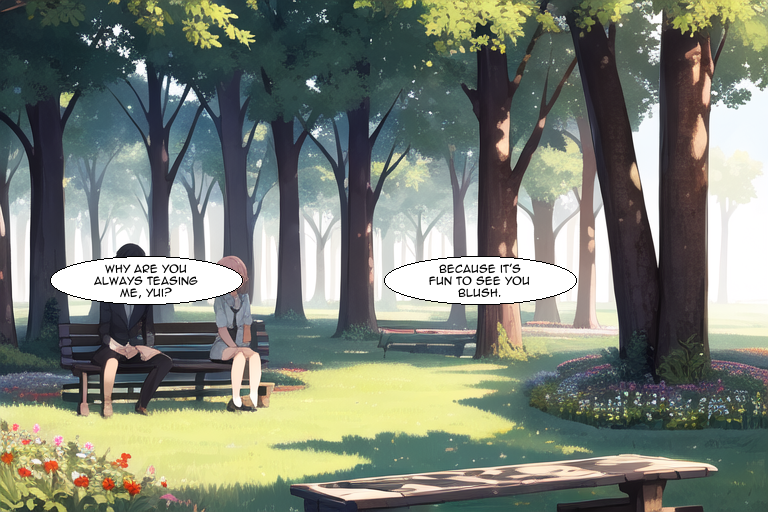

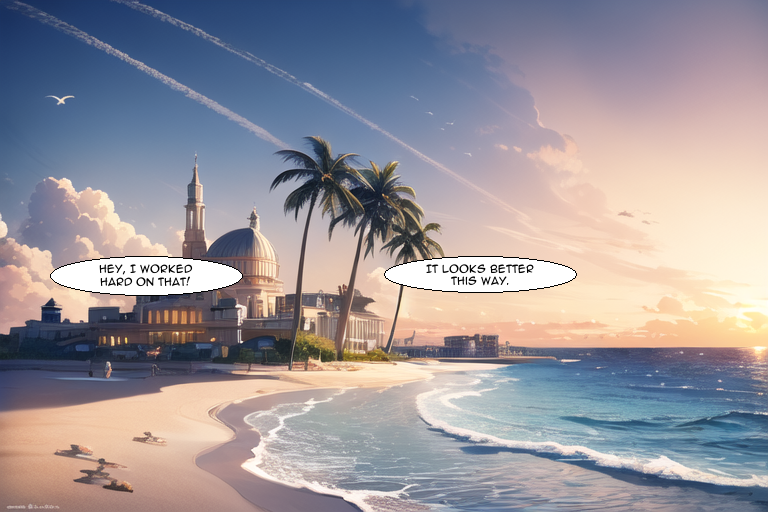

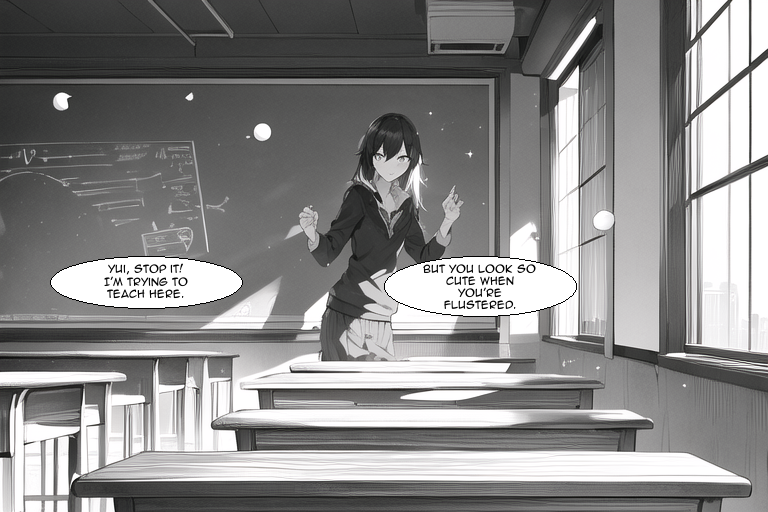

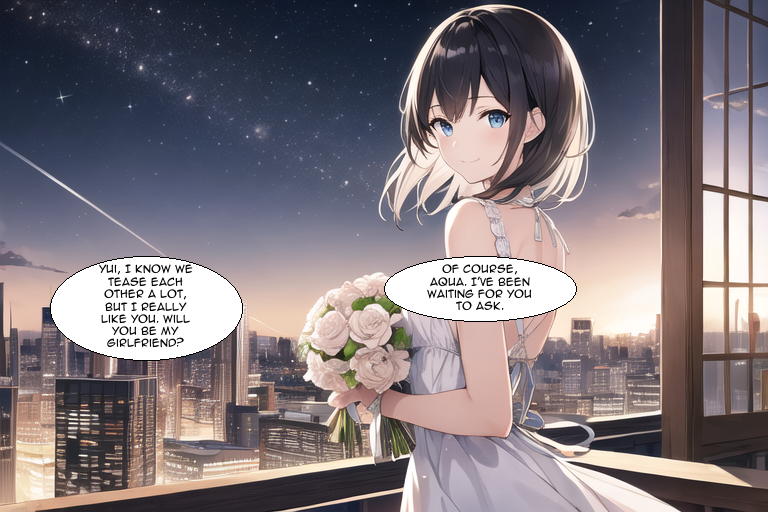

In [9]:
display(panel1_image)
display(panel2_image)
display(panel3_image)
display(panel4_image)